In [1]:
! ls ../input/tokyorepo

tokyo_jpx-0.0.24-py3-none-any.whl


In [2]:


!pip install tokyo-jpx --no-index --find-links=file:///kaggle/input/tokyorepo/ 



Looking in links: file:///kaggle/input/tokyorepo/
Processing /kaggle/input/tokyorepo/tokyo_jpx-0.0.24-py3-none-any.whl


In [3]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
# pl.utilities.seed.seed_everything(seed=42)
import numpy as np
import pandas as pd

from preprocessing.preprocess import (
    show_df, 
    date_features, 
    preprocess, 
    ToTorch, 
    get_loader, 
    ts_split,
    cont_cat_split,
    dataloader_by_stock,
    get_data
) 
from models.dl import NeuralNetwork
from train.trainer import Trainer, plot_loss
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, MaxAbsScaler


from preprocessing.preprocess import (
    show_df, 
    date_features, 
    preprocess, 
    ToTorch, 
    get_loader, 
    get_predict_loader,
    ts_split,
    cont_cat_split,
    dataloader_by_stock,
    get_data,
    dataloader_test_by_stock
)
from metrics.metrics import calc_spread_return_sharpe
from predictions.predict import run_pred_step

In [4]:
ROOT_PATH = "/kaggle/input/jpx-tokyo-stock-exchange-prediction/"
FOLDER = "train_files"
train_df = get_data(folder=FOLDER, root_path=ROOT_PATH)

train_df.head(10):
            Section/Products  33SectorName  17SectorName  Universe0  \
Date                                                                  
2017-01-04                 0             6             8          0   
2017-01-05                 0             6             8          0   
2017-01-06                 0             6             8          0   
2017-01-10                 0             6             8          0   
2017-01-11                 0             6             8          0   
2017-01-12                 0             6             8          0   
2017-01-13                 0             6             8          0   
2017-01-16                 0             6             8          0   
2017-01-17                 0             6             8          0   
2017-01-18                 0             6             8          0   

            MarketCapitalization  SecuritiesCode          RowId    Open  \
Date                                                 

# Config and create model

In [5]:
"""
SUBTRACT:
*) 3 FROM CONTINUOUS COLS BECAUSE OF POOLING
*) 1 FROM CAT_FEATURES TO MAKE MATRICES MATCH AFTER TORCH.CAT
"""
CONT_COLS=['Close', 'Open', 'High', 'Low', 'MarketCapitalization',         
           # 'NetSales', 'EquityToAssetRatio', 'TotalAssets', 'Profit', 
           # 'OperatingProfit', 'EarningsPerShare', 'Equity', 
           # 'BookValuePerShare', 'ResultDividendPerShare1stQuarter', 
           # 'ResultDividendPerShare2ndQuarter', 'ResultDividendPerShare3rdQuarter',
           # 'ResultDividendPerShareFiscalYearEnd', 'ResultDividendPerShareAnnual'
          ]
TS_IN_FEATURES = len(CONT_COLS)
CAT_FEATURES = 4 + 4 - 1 # TEXT_COLS = ['Section/Products', '33SectorName', '17SectorName', 'Universe0']
print('CAT_FEATURES:', CAT_FEATURES)
EMBEDDING_DIM = 300
NO_EMBEDDING = 2000 #2 * len(df_train_cat)


# Create model
def create_model():
    model = None
    model = NeuralNetwork(
        in_features=TS_IN_FEATURES - 3, 
        units=128,
        out_features=1, 
        categorical_dim=CAT_FEATURES,
        no_embedding=NO_EMBEDDING, 
        emb_dim=EMBEDDING_DIM,
        n_blocks=4,
        n_stacks=4,
        dropout=0.1,
        pooling_sizes=3
    )
    return model

CAT_FEATURES: 7


# Train a random choice of stocks

In [6]:
%%time
stocks = train_df['SecuritiesCode'].unique()
count = 0
BATCH_SIZE = 512
weight_decay = 0.1
EPOCHS = 1

scaler_dict = {}

model = create_model()

trainer = Trainer(
    model, 
    optimizer_name='rmsprop', 
    lr=1.3333e-5, 
    weight_decay=weight_decay
)

torch.autograd.set_detect_anomaly(True)

train_loss_list = []
train_mae_list = []
valid_loss_list = []
valid_mae_list = []

"""
SHUFFLE STOCKS WHEN TRAINING
"""
np.random.seed(0)
"""
DO RANDOM CHOICE OF STOCKS.
Run only once
"""
np.random.shuffle(stocks) # SHUFFLE STOCKS IN PLACE

TRAIN_ON_STOCKS = stocks[: 20]
print(stocks)
for no_stock, stock in enumerate(stocks):
    try:
        train_loader, val_dataloader = None, None
        print(f'Stock-iteratation: {no_stock}')
        print(f'Start training for stock: {stock}')
        

        train_dataloader, val_dataloader, scaler = dataloader_by_stock(
            train_df, 
            stock, 
            batch_size=BATCH_SIZE, 
            continous_cols=CONT_COLS,
            return_scaler=True,
            transform=MaxAbsScaler         
        )
        scaler_dict[stock] = scaler

        if stock in TRAIN_ON_STOCKS:
            train_loss, train_mae, val_loss, val_mae = trainer.fit_epochs(
                train_dataloader, 
                val_dataloader, 
                use_cyclic_lr=True, 
                x_cat=True, 
                epochs=EPOCHS
            )

            train_loss_list.extend(train_loss)
            train_mae_list.extend(train_mae)
            valid_loss_list.extend(val_loss)
            valid_mae_list.extend(val_mae)
        
        print('#' * 20)
        print()
        count += 1
    except Exception as e:
        print(f'Training loop: {e}')
    
torch.save(model.state_dict(), './trained_model.pt')
# with open('scaler_dict.pkl', 'wb') as f:
#     pickle.dump(scaler_dict, f)

Using cpu-device
[3457 6779 6586 ... 8355 4100 4550]
Stock-iteratation: 0
Start training for stock: 3457

                    Average train loss: 0.008461205959320069 | 
                    Train-Mae: 0.4390709400177002 |

                    Average val loss: 0.14788198471069336|
                    Val-Mae: 0.37206074595451355
                    
####################

Stock-iteratation: 1
Start training for stock: 6779

                    Average train loss: 0.01543862819671631 | 
                    Train-Mae: 0.37348830699920654 |

                    Average val loss: 0.12923549115657806|
                    Val-Mae: 0.33650994300842285
                    
####################

Stock-iteratation: 2
Start training for stock: 6586

                    Average train loss: 0.002693389356136322 | 
                    Train-Mae: 0.34457606077194214 |

                    Average val loss: 0.11278295516967773|
                    Val-Mae: 0.3142719864845276
                    
######

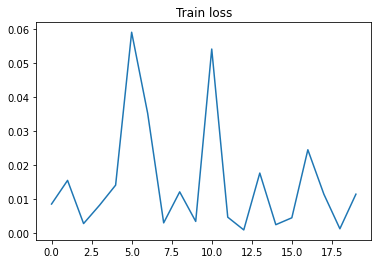

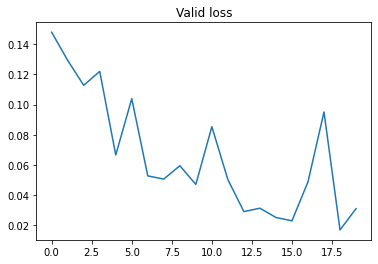

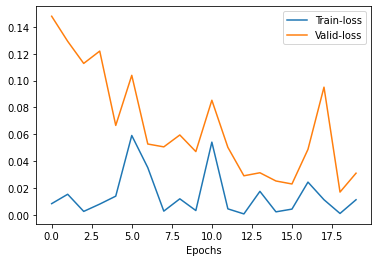

In [7]:
plt.plot(train_loss_list)
plt.title('Train loss');
plt.show()

plt.plot(valid_loss_list)
plt.title('Valid loss')
plt.show()

plot_loss(train_loss_list, valid_loss_list, 'Train-loss', 'Valid-loss')

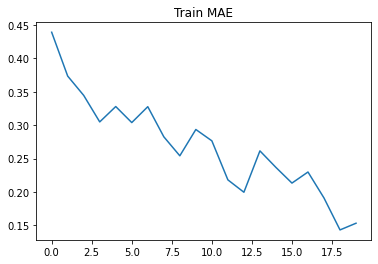

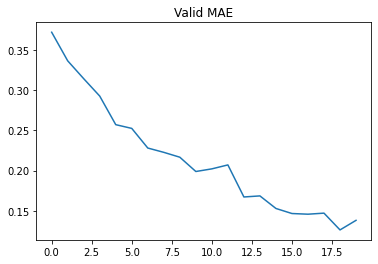

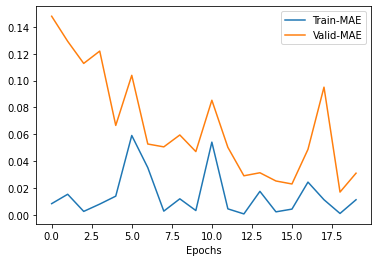

In [8]:
plt.plot(train_mae_list)
plt.title('Train MAE');
plt.show()

plt.plot(valid_mae_list)
plt.title('Valid MAE')
plt.show()

plot_loss(train_loss_list, valid_loss_list, 'Train-MAE', 'Valid-MAE')

# Make predictions and Submit Results 
* TODO: train_dataloader should save all scalers during training even though we not train on all stocks. 

## Rank stocks from model

In [9]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [10]:
# Remove scalers


# sample_prediction_df = pd.DataFrame()
pred_df = pd.DataFrame()
trained_model = model #.load_state_dict(torch.load('./trained_model.pt'))
counter = 0
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    sample_prediction_df = None
    date = np.unique(pd.to_datetime(prices['Date']).dt.strftime('%Y-%m-%d'))[-1]
#     prices['Date'] = pd.to_datetime(prices['Date']).dt.strftime('%Y%m%d').astype(int)
    df = get_data(root_path=ROOT_PATH, prices=prices)
    pred_df = pd.DataFrame()

    
    for count, stock in enumerate(stocks):
        try:
            print('Iteretation:', count)
            # transformer = scaler_dict[stock]
#             train_dataloader, val_dataloader, scaler = dataloader_by_stock(
#                 train_df, 
#                 stock, 
#                 batch_size=BATCH_SIZE, 
#                 continous_cols=CONT_COLS,
#                 return_scaler=True,
#                 transform=MaxAbsScaler       
#             )
            
            scaler = scaler_dict[stock]
            test_dataloader, idx = dataloader_test_by_stock(
                df, 
                stock, 
                transformer=scaler,
                batch_size=BATCH_SIZE, 
                continous_cols=CONT_COLS,
                target_col=None
            )
            pred_list = run_pred_step(test_dataloader, trained_model, x_cat=True)
            df_pred = pd.DataFrame({'SecuritiesCode': stock, 'Target': pred_list}, index=[date]) # maybe index should only be idx
            df_pred.index.rename('Date', inplace=True)
            pred_df = pd.concat([pred_df, df_pred]) 

        except Exception as e:
            print(f'Exception {e}')
        
    sample_prediction_df = sample_prediction
    pred_df['Rank'] = np.int64(pred_df['Target'].rank(method='first',ascending=False).values - 1)
    feature_map = pred_df.set_index('SecuritiesCode')['Rank'].to_dict()
    sample_prediction_df['Rank'] = sample_prediction_df['SecuritiesCode'].map(feature_map)
    sample_prediction_df.Rank = np.int64(sample_prediction_df.Rank)

#     sample_prediction_df['Rank'] = sample_prediction_df['Rank'].astype(int)
#     sample_prediction_df = sample_prediction_df.sort_values('Rank', ascending=True)
    assert sample_prediction_df.Rank.nunique() == 2000
    assert sample_prediction_df.Rank.notna().all()
    assert sample_prediction_df.Rank.min() == 0
    assert sample_prediction_df.Rank.max() == len(sample_prediction_df.Rank) - 1
    print(sample_prediction_df)

    # pred_df = pred_df.sort_values('Target')
#     sample_prediction_df['Target'].hist(figsize=(10, 5), bins=50);
    sample_prediction_df.reset_index(inplace=True)

#     sample_prediction_df['Rank'] = np.arange(len(sample_prediction))  # make your predictions here
    sample_prediction_df = sample_prediction_df[['Date', 'SecuritiesCode', 'Rank']]
    env.predict(sample_prediction_df)  
#     counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
train_df.head(10):
            Section/Products  33SectorName  17SectorName  Universe0  \
Date                                                                  
2021-12-06                 0             6             8          0   
2021-12-06                 0             6             8          0   
2021-12-06                 0             6             8          0   
2021-12-06                 0             6             8          0   
2021-12-06                 0             6             8          0   
2021-12-06                 0             6             8          0   
2021-12-06                 0             6             8          0   
2021-12-06                 2             6             8          0   
2021-12-06                 2             3             3          0   
2021-12-06                 0             3             3          0   

   

In [11]:
len(sample_prediction_df.Rank) - 1, sample_prediction_df.Rank.max()

(1999, 1999)

In [12]:
len(sample_prediction_df.Rank) - 1, sample_prediction_df.Rank.max() 

(1999, 1999)

In [13]:
sample_prediction_df.Rank.nunique(), sample_prediction_df.Rank.unique() ,sample_prediction_df.Rank.min(), sample_prediction_df.Rank.max()

(2000, array([1309, 1175,  821, ..., 1576, 1074,  680]), 0, 1999)

In [14]:
sample_prediction_df.Rank.mean(), sample_prediction_df.Rank.min(), sample_prediction_df.Rank.std()

(999.5, 0, 577.4945887192364)

In [15]:
sample_prediction_df

,Date,SecuritiesCode,Rank
0,2021-12-07,1301,1309
1,2021-12-07,1332,1175
2,2021-12-07,1333,821
3,2021-12-07,1375,983
4,2021-12-07,1376,1515
...,...,...,...
1995,2021-12-07,9990,460
1996,2021-12-07,9991,814
1997,2021-12-07,9993,1576
1998,2021-12-07,9994,1074


# Utility functions and classes

# Models

In [16]:
ROOT_PATH = '/kaggle/input/jpx-tokyo-stock-exchange-prediction'

# Start data analysis 

### API data

## Models
Todo:

    1) Preprocesses data and use correct features (date features, etc)
    2) Deep learning for prediction of stock-returns
    3) Ranking with XGBoost or other methods